# Genes and SNP effects

This notebook illustrates how to use data from Ag1000G phase 3 to investigate SNPs in a gene of interest. This includes computing the effects of SNPs on the protein sequence, and computing allele frequencies in different mosquito populations. 

As usual this notebook is executable, click the launch icon above (<i class="fas fa-rocket"></i>) to run it for yourself. Note in particular that, although this notebook uses the *Rdl* gene as an example, if you run this notebook yourself you can change this to investigate any gene you are interested in.


## Setup

Install the packages we'll need. If you're working on MyBinder, you can skip this step, packages will already be installed.

In [1]:
!pip install -q malariagen_data bokeh

Import packages.

In [2]:
import numpy as np
import bokeh.plotting
import bokeh.models
import bokeh.layouts
import bokeh.io
import bokeh.palettes
import pandas as pd
import malariagen_data

In this notebook we'll be making some interactive plots using the [bokeh](https://docs.bokeh.org/en/latest/index.html) package. Previously, in some of the other analysis notebooks, we used a different plotting package called [plotly](https://plotly.com/python/). We're using bokeh here rather than plotly simply because for some of the plots we want to create here, bokeh has slightly better functionality. Each of these plotting libraries has its own strengths and limitations, and it's worth having some familiarity with both, so you can pick the best tool for the job at hand.

Set up plotting with bokeh in the notebook.

In [3]:
bokeh.io.output_notebook()

Loading BokehJS ...

Setup access to MalariaGEN data in Google Cloud.

In [4]:
ag3 = malariagen_data.Ag3()
ag3

<MalariaGEN Ag3 data resource API>
Storage URL           : gs://vo_agam_release/
Releases available    : 3.0
Cohorts analysis      : 20211101
Species analysis      : aim_20200422
Site filters analysis : dt_20200416
---
Please note that data are subject to terms of use,
for more information see https://www.malariagen.net/data
or contact data@malariagen.net. For API documentation see: https://malariagen.github.io/vector-data/ag3/api.html

## Preamble: gene annotations

In this notebook we'll be making use of gene annotations. Gene annotations provide information on which regions of the genome contain DNA sequences that encode genes, which are transcribed and spliced into messenger RNA (mRNA) and then translated to make proteins.

Gene annotations for the *Anopheles gambiae* (AgamP4) genome are available from [VectorBase](https://vectorbase.org/vectorbase/app/). For convenience, we've added some functionality to the `malariagen_data` package for loading these gene annotations into a pandas data frame. Let's take a look.

In [5]:
df_geneset = ag3.geneset().set_index("ID")
df_geneset

,contig,source,type,start,end,score,strand,phase,Parent,Name,description
ID,,,,,,,,,,,
2L,2L,VectorBase,chromosome,1,49364325,NaN,NaN,NaN,NaN,NaN,NaN
AGAP004677,2L,VectorBase,gene,157348,186936,NaN,-,NaN,NaN,NaN,methylenetetrahydrofolate dehydrogenase(NAD ) ...
AGAP004677-RA,2L,VectorBase,mRNA,157348,181305,NaN,-,NaN,AGAP004677,NaN,NaN
NaN,2L,VectorBase,three_prime_UTR,157348,157495,NaN,-,NaN,AGAP004677-RA,NaN,NaN
NaN,2L,VectorBase,exon,157348,157623,NaN,-,NaN,AGAP004677-RA,AGAP004677-RB-E4,NaN
...,...,...,...,...,...,...,...,...,...,...,...
NaN,Y_unplaced,VectorBase,five_prime_UTR,47932,48111,NaN,+,NaN,AGAP029375-RA,NaN,NaN
NaN,Y_unplaced,VectorBase,exon,47932,48138,NaN,+,NaN,AGAP029375-RA,AGAP029375-RA-E2,NaN
AGAP029375-PA,Y_unplaced,VectorBase,CDS,48112,48138,NaN,+,0.0,AGAP029375-RA,NaN,NaN


Each row of this data frame is a "feature", which is a general term meaning some kind of annotation on the reference genome. The `type` column tells us what kind of feature, and the `seqid`, `start` and `end` columns tell us where the feature is located within the reference genome sequence. The `strand` column tells us whether this feature is read using the forward ("+") or reverse ("-") strand of the DNA sequence. 

For example, the second row is a "gene" feature, which occurs on chromosome arm 2L, starting at position 157,348 and ending at position 186,936. The identifier for this gene is "AGAP004677". This gene hasn't been given a name, but does have a description, which may tell us something about the function of the protein that this gene encodes (in this case, a methylenetetrahydrofolate dehydrogenase). 

### Genes

To get a bit more intuition for gene annotations, let's make an interactive plot of all the gene annotations in the geneset. We will plot each gene as a rectangle showing it's location on a chromosome arm.

In [6]:
def plot_genes(contig, width=750, height=150):

    # select the gene rows within the given contig
    df_geneset = ag3.geneset(attributes=["ID", "Name", "Parent", "description"]).set_index("ID")
    data = df_geneset.query(f"type == 'gene' and contig == '{contig}'").copy()

    # plot each gene as a rectangle - add some columns to define rectangle
    # coordinates
    data['left'] = data['start'] / 1e6  # plot in Mbp coordinates
    data['right'] = data['end'] / 1e6  # plot in Mbp coordinates
    data['bottom'] = np.where(data['strand'] == '+', 1, 0)
    data['top'] = data['bottom'] + 0.8

    # tidy up some columns for presentation
    data['Name'].fillna('', inplace=True)
    data['description'].fillna('', inplace=True)

    # determine how long the contig is
    contig_length = len(ag3.genome_sequence(contig))

    # define tooltips for hover
    tooltips = [
        ("ID", '@ID'),
        ("Name", '@Name'),
        ("Description", '@description'),
    ]

    # make a figure
    fig = bokeh.plotting.figure(
        title=f'Genes - {contig}',
        plot_width=width, 
        plot_height=height,
        tools='xpan,xzoom_in,xzoom_out,xwheel_zoom,reset,tap,hover',
        toolbar_location='above',
        active_scroll='xwheel_zoom',
        active_drag='xpan',
        tooltips=tooltips,
    )

    # add functionality to click through to vectorbase
    url = f'https://vectorbase.org/vectorbase/app/record/gene/@ID'
    taptool = fig.select(type=bokeh.models.TapTool)
    taptool.callback = bokeh.models.OpenURL(url=url)

    # now plot the genes as rectangles
    fig.quad(bottom='bottom', top='top', left='left', right='right',
             source=data, line_width=.5, fill_alpha=.5)

    # tidy up the plot
    fig.x_range = bokeh.models.Range1d(0, contig_length/1e6, bounds='auto')
    fig.xaxis.axis_label = f'Position (Mbp)'
    fig.y_range = bokeh.models.Range1d(-.5, 2.3)
    fig.ygrid.visible = False
    yticks = [0.4, 1.4]
    yticklabels = ['rev', 'fwd']
    fig.yaxis.ticker = yticks
    fig.yaxis.major_label_overrides = {k: v for k, v in zip(yticks, yticklabels)}
    fig.yaxis.axis_label = f'Strand'

    # show the plot
    bokeh.plotting.show(fig)


In [7]:
plot_genes("2L")

When zoomed out to an entire chromosome arm like in the plot above, it is hard to see the individual genes. However, you can zoom in to any region by using the mouse wheel or the tool icons at the top right of the plot. If you hover over a gene, you'll hopefully see its ID, as well as its name and description if it has them. If you click on a gene, you'll be taken to the corresponding gene page on VectorBase. 

If you'd like a challenge, try find the resistance to dieldrin (*Rdl*) gene, it's on 2L and starts at around position 25.36 Mbp.

### Transcripts

Genes are transcribed into mRNA, which means that the DNA sequence from the gene region is "read" and used as a template to build an mRNA molecule with an equivalent nucleotide sequence. For many genes, this process of transcription is followed by splicing, which means that parts of the sequence are cut out before the mRNA is translated into protein. The parts of the gene sequence that are cut out are called "introns". The parts of the gene sequence that are kept and included in the final mRNA molecule are called "exons".

Mostly the exons comprise DNA sequence that is translated into an amino acid sequence, and these protein-coding segments are called "CDSs", which stands for coding sequences. Some genes also include "UTRs" which are untranslated regions at the start and end of the gene sequence. These UTRs are included in the exons but do not get translated into protein. A UTR at the start of the gene is called a "five prime UTR" and a UTR at the end of a gene is called a "three prime UTR".

Let's build some intuition by looking up the transcripts for the doublesex gene, AGAP004050.

In [8]:
df_geneset.query("Parent == 'AGAP004050'")

,contig,source,type,start,end,score,strand,phase,Parent,Name,description
ID,,,,,,,,,,,
AGAP004050-RA,2R,VectorBase,mRNA,48703664,48788460,NaN,-,NaN,AGAP004050,NaN,NaN
AGAP004050-RB,2R,VectorBase,mRNA,48703664,48788460,NaN,-,NaN,AGAP004050,NaN,NaN


Note that there are two rows here, each with `type` "mRNA". This means that the doublesex gene has two mRNA transcripts. This is a complexity that arises for many genes, where the gene may be transcribed and then spliced in different ways. Each transcript may include different exons, or exons may vary in length. The purpose of alternative splicing is to allow the same gene to encode different proteins, which may perform different functions. In this case, the gene is part of the sex determination pathway, and which of these two transcripts is produced will determine whether a mosquito is male or female.

Let's make a function to visualise these transcripts.

In [9]:
def plot_transcript(transcript, width=700, height=120, show=True, x_range=None,
                    toolbar_location='above'):

    # find the gene
    df_geneset = ag3.geneset().set_index("ID")
    parent  = df_geneset.loc[transcript]

    # define tooltips for hover
    tooltips = [
        ("Type", '@type'),
        ("Location", '@contig:@start{,}..@end{,}'),
    ]

    # make a figure
    fig = bokeh.plotting.figure(
        title=f'Transcript - {transcript} ({parent.strand})',
        plot_width=width, 
        plot_height=height,
        tools='xpan,xzoom_in,xzoom_out,xwheel_zoom,reset,hover',
        toolbar_location=toolbar_location,
        active_scroll='xwheel_zoom',
        active_drag='xpan',
        tooltips=tooltips,
        x_range=x_range,
    )

    # find child components of the transcript
    data = df_geneset.query(f"Parent == '{transcript}'").copy()
    data['left'] = data['start'] / 1e6  # plot in Mbp coordinates
    data['right'] = data['end'] / 1e6  # plot in Mbp coordinates
    data['bottom'] = -0.4
    data['top'] = 0.4

    # plot exons
    exons = data.query("type == 'exon'")
    fig.quad(bottom='bottom', top='top', left='left', right='right',
             source=exons, fill_color=None, line_color='black', line_width=.5, 
             fill_alpha=0)
    
    # plot introns
    for l, r in zip(exons[:-1]['right'], exons[1:]['left']):
        m = (l + r) / 2
        fig.line([l, m, r], [0, .1, 0], line_width=1, line_color="black")

    # plot UTRs
    fig.quad(bottom='bottom', top='top', left='left', right='right',
                source=data.query("type == 'five_prime_UTR'"), 
                fill_color='green', line_width=0, fill_alpha=.5)
    fig.quad(bottom='bottom', top='top', left='left', right='right',
                source=data.query("type == 'three_prime_UTR'"), 
                fill_color='red', line_width=0, fill_alpha=.5)

    # plot CDSs
    fig.quad(bottom='bottom', top='top', left='left', right='right',
             source=data.query("type == 'CDS'"), 
             fill_color='blue', line_width=0, fill_alpha=.5)

    fig.yaxis.ticker = []
    fig.xaxis.axis_label = f'Position (Mbp)'
    fig.y_range = bokeh.models.Range1d(-.6, .6)

    fig.xaxis.axis_label = f'Contig {parent.contig} position (Mbp)'

    # show the figure
    if show:
        bokeh.plotting.show(fig)

    return fig


Visualise transcripts for the doublesex gene (AGAP004050). 

In [10]:
plot_transcript("AGAP004050-RA");

In [11]:
plot_transcript("AGAP004050-RB");

The boxes are exons and the connecting lines are introns. CDSs are coloured in blue, five prime UTRs coloured in green, and three prime UTRs coloured in red. You can hopefully see that AGAP004050-RB includes an exon which is missing in AGAP004050-RA - this difference in splicing is what determines gender. Note this gene is on the negative (-) strand, meaning it is read from right to left.

Let's look at another example, the resistance to dieldrin (*Rdl*) gene AGAP006028.

In [12]:
df_geneset.query("Parent == 'AGAP006028'")

,contig,source,type,start,end,score,strand,phase,Parent,Name,description
ID,,,,,,,,,,,
AGAP006028-RA,2L,VectorBase,mRNA,25363652,25434556,NaN,+,NaN,AGAP006028,NaN,NaN
AGAP006028-RB,2L,VectorBase,mRNA,25363652,25434556,NaN,+,NaN,AGAP006028,NaN,NaN
AGAP006028-RC,2L,VectorBase,mRNA,25363652,25434556,NaN,+,NaN,AGAP006028,NaN,NaN


In [13]:
plot_transcript("AGAP006028-RA");

In [14]:
plot_transcript("AGAP006028-RB");

In [15]:
plot_transcript("AGAP006028-RC");

Here there are three transcripts. Some exons are present in some transcripts but not others. Note that there are no untranslated regions (UTRs) in any of the transcripts, this is the case for some genes.

OK, now we've introduced gene annotations, let's look at SNP effects.

## SNP effects

Once we have identified a gene of interest, and chosen which transcript to study, we can compute the effect that any given SNP will have on the resulting protein sequence. The effect will depend on two things. Firstly, what is the nucleotide change? Secondly, where does the SNP fall within the transcript? 

If a SNP falls within a CDS then it may change the protein sequence. However, not all SNPs in CDSs will do so, because the [genetic code](https://en.wikipedia.org/wiki/Genetic_code) has some redundancy, meaning that different DNA sequences can encode the same amino acid sequence. If a SNP in a CDS does change the amino acid sequence, it is called a "non-synonymous" or "missense" SNP. If the SNP does not change the amino acid sequence, it is called a "synonymous" SNP. 

If a SNP falls within a UTR then it won't have any effect on the amino acid sequence. It might still affect the level of transcription of the gene, but that is harder to predict.

If a SNP falls within an intron, again it won't change the amino acid sequence. It might, however, affect how the gene is spliced, if the SNP falls close to an intron/exon boundary. Any change in splicing might have a big effect on the amino acid sequence, because it could result in parts of the amino acid sequence being added or removed.

Based on this information, the effect of any given SNP can be categorised based on the predicted impact on the protein structure. Here is a list of the main effects we'll be interested in, grouped by their predicted impact.

* **HIGH** impact - may significantly disrupt or alter protein function.
  * **START_LOST** - SNP causes loss of the start codon. The start codon in mRNA is the first to be translated by the ribosome. If the start codon is changed to a non-start codon, no translation will take place.
  * **STOP_LOST** - SNP causes loss of the start codon. The stop codon in mRNA signals the end of translation. If the variant causes the stop codon to be lost, elongated proteins will be formed.
  * **STOP_GAINED** - SNP causes a new stop codon to be formed, and the protein may be truncated prematurely.
  * **SPLICE_CORE** - The SNP occurs within 2 bp of an intron boundary. This can affect splicing and result in excluded exons or included introns, altering the protein sequence.
* **MODERATE** impact - may change protein function.
  * **NON_SYNONYMOUS_CODING** - SNP is within a CDS and causes an amino acid change. This protein-altering variant is often what we are interested in when looking at insecticide resistance mutations such as *kdr*.
  * **SPLICE_REGION** - SNP is close to a splice site so may affect exon splicing.
* **LOW** impact - unlikely to change protein function.
  * **SYNONYMOUS_CODING** - SNP is within a CDS but does not cause an amino acid change.
  * **FIVE_PRIME_UTR** - SNP is within the five prime untranslated region.
  * **THREE_PRIME_UTR** - SNP is within the three prime untranslated region.
* **MODIFIER** - very unlikely to change protein function.
  * **INTRONIC** - SNP falls with an intron, not near any splice regions.

To compute SNP effects for a given gene transcript, we've added a `snp_effects()` method to the [Ag3 Python API](../api). Let's see it in action, again using the *Rdl* gene (AGAP006028) as an example. 

In [16]:
# Rdl gene, first transcript - change this to investigate a different gene or transcript
transcript = "AGAP006028-RA"

# compute effects for all SNPs in chosen transcript
df_effects = ag3.snp_effects(
    transcript=transcript, 
)
df_effects

,contig,position,ref_allele,alt_allele,pass_gamb_colu_arab,pass_gamb_colu,pass_arab,transcript,effect,impact,ref_codon,alt_codon,aa_pos,ref_aa,alt_aa,aa_change
0,2L,25363652,A,C,True,True,True,AGAP006028-RA,START_LOST,HIGH,Atg,Ctg,1.0,M,L,M1L
1,2L,25363652,A,T,True,True,True,AGAP006028-RA,START_LOST,HIGH,Atg,Ttg,1.0,M,L,M1L
2,2L,25363652,A,G,True,True,True,AGAP006028-RA,START_LOST,HIGH,Atg,Gtg,1.0,M,V,M1V
3,2L,25363653,T,A,True,True,True,AGAP006028-RA,NON_SYNONYMOUS_CODING,MODERATE,aTg,aAg,1.0,M,K,M1K
4,2L,25363653,T,C,True,True,True,AGAP006028-RA,NON_SYNONYMOUS_CODING,MODERATE,aTg,aCg,1.0,M,T,M1T
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212710,2L,25434555,A,T,True,True,True,AGAP006028-RA,STOP_LOST,HIGH,tAa,tTa,556.0,*,L,*556L
212711,2L,25434555,A,G,True,True,True,AGAP006028-RA,SYNONYMOUS_CODING,LOW,tAa,tGa,556.0,*,*,*556*
212712,2L,25434556,A,C,True,True,True,AGAP006028-RA,STOP_LOST,HIGH,taA,taC,556.0,*,Y,*556Y
212713,2L,25434556,A,T,True,True,True,AGAP006028-RA,STOP_LOST,HIGH,taA,taT,556.0,*,Y,*556Y


The `snp_effects()` method requires a `transcript` parameter, and here we used "AGAP006028-RA", which is the first transcript listed in the geneset for the *Rdl* gene. Recall that there are two other transcripts for this gene, and the effects may be different for different transcripts.

The data frame that is returned contains the SNP effects for every alternative allele at every position within the transcript. The `effect` and `impact` columns provide information about the likely effect of the SNP. If the SNP is non-synonymous, the `aa_change` column gives the amino acid substitution. 

Using pandas, we can take a closer look at features of this data frame, like the counts of different effects.  

In [17]:
df_effects.groupby(['impact', 'effect']).size()

impact    effect               
HIGH      SPLICE_CORE                  96
          START_LOST                    3
          STOP_GAINED                 197
          STOP_LOST                     7
LOW       SYNONYMOUS_CODING          1163
MODERATE  NON_SYNONYMOUS_CODING      3634
          SPLICE_REGION               240
MODIFIER  INTRONIC                 207375
dtype: int64

Note that there are SNPs here that could alter the protein function. However, it is important to note that **not all of the SNPs will have been observed in the `Ag3.0` dataset**. In other words, we also need some information about the **allele frequencies** in order to determine if any of these SNPs are present in natural mosquito populations. 

## SNP allele frequencies

Here, our aim is to discover any SNPs in our gene of interest that (1) are present in one or more mosquito populations, and (2) may affect protein function. For example, if we are studying an insecticide resistance gene like *Rdl* or *Vgsc*, we want to discover non-synonymous SNPs that might be causing insecticide resistance.

To calculate allele frequencies, use the `snp_allele_frequencies()` method. 

These queries use the [pandas query syntax](https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#the-query-method). Here's the full list of columns you can query on.

Now compute allele frequencies for these populations in our gene of interest (may take a minute or two).

In [18]:
df_af = ag3.snp_allele_frequencies(
    transcript=transcript, 
    cohorts="admin1_year", 
    sample_sets="3.0",
    sample_query="country in ['Burkina Faso', 'Uganda']"
)
df_af

pass_gamb_colu_arab  \
contig position ref_allele alt_allele aa_change                        
2L     25363656 C          T          S2L                       True   
                           G          S2W                       True   
       25363657 G          A          S2S                       True   
       25363659 T          A          L3Q                       True   
       25363670 G          A          V7I                       True   
...                                                              ...   
       25434523 C          A          A545A                     True   
       25434526 C          T          D546D                     True   
       25434532 G          A          L548L                     True   
       25434538 G          A          L550L                     True   
       25434550 G          A          E554E                     True   

                                                 pass_gamb_colu  pass_arab  \
contig position ref_allele alt_allele aa_change                              
2L     25363656 C          T          S2L                  True       True   
                           G          S2W                  True       True   
       25363657 G          A          S2S                  True       True   
       25363659 T          A          L3Q                  True       True   
       25363670 G          A          V7I                  True       True   
...                                                         ...        ...   
       25434523 C          A          A545A                True       True   
       25434526 C          T          D546D                True       True   
       25434532 G          A          L548L                True       True   
       25434538 G          A          L550L                True       True   
       25434550 G          A          E554E                True       True   

                                                 frq_BF-07_gamb_2004  \
contig position ref_allele alt_allele aa_change                        
2L     25363656 C          T          S2L                   0.000000   
                           G          S2W                   0.000000   
       25363657 G          A          S2S                   0.000000   
       25363659 T          A          L3Q                   0.000000   
       25363670 G          A          V7I                   0.000000   
...                                                              ...   
       25434523 C          A          A545A                 0.038462   
       25434526 C          T          D546D                 0.000000   
       25434532 G          A          L548L                 0.000000   
       25434538 G          A          L550L                 0.038462   
       25434550 G          A          E554E                 0.000000   

                                                 frq_BF-09_colu_2012  \
contig position ref_allele alt_allele aa_change                        
2L     25363656 C          T          S2L                        0.0   
                           G          S2W                        0.0   
       25363657 G          A          S2S                        0.0   
       25363659 T          A          L3Q                        0.0   
       25363670 G          A          V7I                        0.0   
...                                                              ...   
       25434523 C          A          A545A                      0.0   
       25434526 C          T          D546D                      0.0   
       25434532 G          A          L548L                      0.0   
       25434538 G          A          L550L                      0.0   
       25434550 G          A          E554E                      0.0   

                                                 frq_BF-09_colu_2014  \
contig position ref_allele alt_allele aa_change                        
2L     25363656 C          T          S2L                        0.0   
       

The allele frequencies are given in columns named after the cohorts. The allele frequency is given as a fraction, e.g., 1.0 means all samples carry the alternate allele, 0.5 means half the samples carry the alternate allele, and 0 means all samples carry the reference allele.

OK, now we're ready to analyse our gene of interest for important SNPs.

## Analysis

We can use the SNP effects and allele frequencies we have calculated to investigate the genetic variation present in our gene and populations of interest. Let's filter the data frame of SNPs, e.g., below we keep only non-synonymous SNPs. We can also remove any low frequency SNPs, where there is an allele frequency of less than 2% across all populations of interest.


In [19]:
df_snps_filtered = df_af.query("effect == 'NON_SYNONYMOUS_CODING' and max_af > 0.02")
df_snps_filtered

pass_gamb_colu_arab  \
contig position ref_allele alt_allele aa_change                        
2L     25363685 A          T          S12C                      True   
       25387104 A          C          E79D                      True   
       25429235 G          T          A296S                     True   
       25429236 C          G          A296G                     True   
       25433170 A          T          T345S                    False   
       25433171 C          T          T345M                     True   
       25433207 A          T          K357M                     True   
       25433254 C          A          Q373K                     True   
       25434478 T          A          N530K                     True   
       25434500 C          G          L538V                     True   
       25434505 C          G          H539Q                     True   
       25434512 G          A          D542N                     True   

                                                 pass_gamb_colu  pass_arab  \
contig position ref_allele alt_allele aa_change                              
2L     25363685 A          T          S12C                 True       True   
       25387104 A          C          E79D                 True       True   
       25429235 G          T          A296S                True       True   
       25429236 C          G          A296G                True       True   
       25433170 A          T          T345S               False      False   
       25433171 C          T          T345M                True       True   
       25433207 A          T          K357M                True       True   
       25433254 C          A          Q373K                True       True   
       25434478 T          A          N530K                True       True   
       25434500 C          G          L538V                True       True   
       25434505 C          G          H539Q                True       True   
       25434512 G          A          D542N                True       True   

                                                 frq_BF-07_gamb_2004  \
contig position ref_allele alt_allele aa_change                        
2L     25363685 A          T          S12C                  0.000000   
       25387104 A          C          E79D                  0.000000   
       25429235 G          T          A296S                 0.000000   
       25429236 C          G          A296G                 0.384615   
       25433170 A          T          T345S                 0.000000   
       25433171 C          T          T345M                 0.384615   
       25433207 A          T          K357M                 0.000000   
       25433254 C          A          Q373K                 0.038462   
       25434478 T          A          N530K                 0.000000   
       25434500 C          G          L538V                 0.038462   
       25434505 C          G          H539Q                 0.038462   
       25434512 G          A          D542N                 0.038462   

                                                 frq_BF-09_colu_2012  \
contig position ref_allele alt_allele aa_change                        
2L     25363685 A          T          S12C                  0.048780   
       25387104 A          C          E79D                  0.024390   
       25429235 G          T          A296S                 0.634146   
       25429236 C          G          A296G                 0.006098   
       25433170 A          T          T345S                 0.585366   
       25433171 C          T          T345M                 0.006098   
       25433207 A          T          K357M                 0.012195   
       25433254 C          A          Q373K                 0.000000   
       25434478 T          A          N530K                 0.000000   
       25434500 C          G          L538V                 0.000000   
       25434505 C          G          H539Q                 0.000000   
  

We can visualise these frequencies as a heatmap.

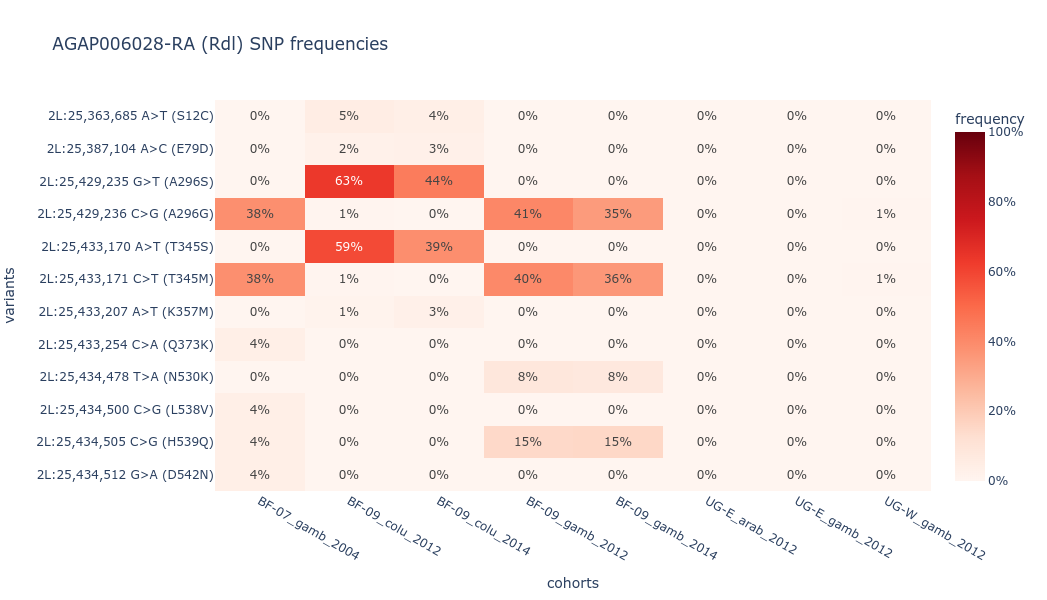

In [25]:
ag3.plot_frequencies_heatmap(df_snps_filtered, height=600, width=700)

We can also make a plot to help visualise these data in their genomic context.

In [21]:
def plot_snps(transcript, data, width=750, height=300, palette='Category10'):
    data = data.reset_index()

    # hover tooltips
    tooltips = [
        ("position", '@contig:@position{,}'),
        ("alleles", '@ref_allele>@alt_allele'),
        ("pass", "@pass_gamb_colu_arab, @pass_gamb_colu, @pass_arab"),
        ("impact", '@impact'),
        ("effect", '@effect'),
        ("aa_change", '@aa_change'),
        ("frequency", '@frequency{%f} (@cohort)'),
    ]

    fig1 = bokeh.plotting.figure(
        title=f'Transcript - {transcript}',
        tools='xpan,xzoom_in,xzoom_out,xwheel_zoom,reset,hover',
        active_scroll='xwheel_zoom',
        active_drag='xpan',
        plot_width=width, 
        plot_height=height, 
        tooltips=tooltips,
        toolbar_location="above")

    # set up colors
    frq_cols = [c for c in data.columns if c.startswith("frq_")]
    cohorts = [c.split("frq_")[1] for c in frq_cols]
    palette = bokeh.palettes.all_palettes[palette]
    colors = palette[len(cohorts)]

    # plot allele frequencies
    for coh, color in zip(cohorts, colors):
        df = data.copy()
        # add X coordinate in Mbp
        df['x'] = df['position'] / 1e6
        df['frequency'] = df[f"frq_{coh}"]
        df['cohort'] = coh
        fig1.triangle("x", "frequency", 
                      size=8, 
                      color=color,
                      source=df,
                      legend_label=coh)

    # tidy up the plot
    fig1.y_range = bokeh.models.Range1d(0, 1)
    fig1.yaxis.axis_label = f'Alt allele frequency'
    fig1.xaxis.visible = False
    fig1.add_layout(fig1.legend[0], 'right')
    fig1.legend.click_policy="hide"

    # plot transcript
    fig2 = plot_transcript(transcript, width=width, height=80, show=False, 
                           x_range=fig1.x_range)
    fig2.toolbar.logo = None 
    fig2.toolbar_location = None
    fig2.title = None

    bokeh.plotting.show(bokeh.layouts.column(fig1, fig2))


In [22]:
plot_snps(transcript, data=df_snps_filtered)

A few points to note about these plots:

* Each triangular marker on the plot shows the frequency of a SNP allele in one of the five cohorts we selected, and its position on the X axis shows its location within the *Rdl* gene.

* Zooming in using the mouse wheel or plot toolbar we can see that SNPs only occur within CDSs. This is because we only selected SNPs with a `NON_SYNONYMOUS_CODING` effect.

* Hovering the mouse pointer over one of the markers gives detailed information about that SNP, including frequency, position and amino acid change.

* If overplotting becomes an issue due to SNPs at the same position and frequency in different cohorts, individual cohorts be turned on and off by clicking the colour legend.

* By zooming in to around 25.429Mbp we can see the Burkina Faso *An. gambiae* cohorts carry a known insecticide resistance SNP A296G, conferring resistance to dieldrin. In 2012 it was at a frequency of 41%, falling to 35% in 2014. Nearby, the T345M variant can be seen at very similar frequencies in these cohorts. 

* In the Burkina Faso *An. coluzzii* cohorts, a different SNP A296S is at high frequency, present at 63% in 2012 and 44% in 2012. This SNP also confers dieldrin resistance. These cohorts also carry a T345S SNP at similar frequencies.

The overall picture here appears to be that there are two combinations of resistance alleles. The combination A296G+T345M is common in Burkina Faso *An. gambiae*, whereas the combination A296S+T345S is common in *An. coluzzii*. Further details of these resistance SNPs can be found in [Grau-Bové et al. (2020)](https://academic.oup.com/mbe/article/37/10/2900/5843798?login=true).

The presence of these resistance alleles is interesting for two reasons.

Firstly, the tight linkage of SNPs in codons 296 and 345 strongly suggests that these amino acids have an important association within the protein structure, and that mutations in both codons are required to confer resistance. 

Secondly, dieldrin hasn't been used since the 1970s due to it's high environmental persistance, and so the presence of these SNPs at relatively high frequency is surprising. In general, we expect that resistance alleles will disappear from mosquito populations over time, once the insecticides are no longer used. The temporal data from Burkina Faso suggests these alleles may be falling in frequency, but it is perhaps surprising that they had not already fallen to lower levels. 

One final technical point, the T345S SNP fails our site filters. In general it is a good idea to only study SNPs that pass site filters, but site filters can in some cases be too conservative, and this may be the case here.

## Further reading

Hopefully this notebook has been a useful introduction to analysing SNPs in genes. Don't forget you can use this notebook to analyse any gene of interest. If you have any comments, questions or suggestions, please feel free to [get in touch](https://github.com/malariagen/vector-data/discussions). 

This notebook is part of the [Ag1000G phase 3 user guide](../intro). See the menu at the left for more documentation and example analyses.

If you're interested to read more about the *Rdl* gene, check out:

* [Grau-Bové et al. (2020)](https://academic.oup.com/mbe/article/37/10/2900/5843798?login=true) *Evolution of the Insecticide Target Rdl in African Anopheles Is Driven by Interspecific and Interkaryotypic Introgression*